# Split the watershed

In [32]:
import matplotlib.pyplot as plt
import pathlib as pl
import numpy as np
import flopy
from flopy.mf6.utils import Mf6Splitter

from defaults import *

### Get the model directories for the base and the parallel simulations

In [33]:
base_dir = get_base_dir()
parallel_dir = get_parallel_dir()

### Load base simulation data

In [34]:
base_sim = flopy.mf6.MFSimulation.load(
    sim_ws=base_dir,
)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package drn...
    loading package drn...
    loading package oc...
  loading solution package model...


there is only one model in there:

In [35]:
gwf = base_sim.get_model()
nrow = gwf.modelgrid.nrow
ncol = gwf.modelgrid.ncol

### Split into domains

Decide in how many domains you want to split. You might want to check how many cores you have. On Windows this will show in the Task manager:


<img src="./cpus.png" alt="drawing" width="700"/>

On Linux you can run the `lscpu` command and look for `Core(s) per socket:`.

In [36]:
nr_domains = 2

Create the FloPy Model Splitter

In [37]:
mfsplit = Mf6Splitter(base_sim)

Create the splitting array to assign groups of cells to a domain number. We either use Metis for partitioning or, apply a straightforward division into rectangular slices

In [38]:
use_metis = False
if use_metis:
 split_array = mfsplit.optimize_splitting_mask(nparts=nr_domains)
else:
  split_array = np.zeros((nrow, ncol), dtype=int)
  for irow in range(nrow):
    for icol in range(ncol):      
      isub = np.floor(icol / (ncol / nr_domains))
      split_array[irow, icol] = isub

Plot the splitting array as a plan view and cut the inactive cells out

In [39]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

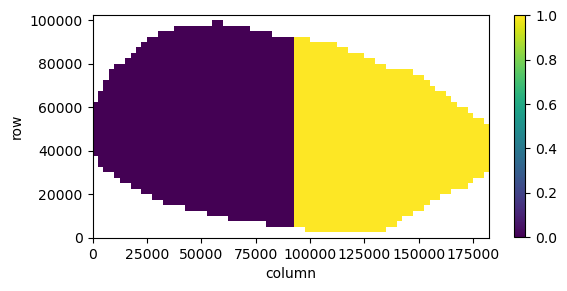

In [40]:
pmv = flopy.plot.PlotMapView(model=gwf, layer=0)
pa = pmv.plot_array(split_array)
pmv.plot_inactive(color_noflow="white")
plt.ylabel("row")
plt.xlabel("column")
plt.colorbar(pa, shrink=0.6)

### Split the simulation into domains

In [41]:
parallel_sim = mfsplit.split_model(split_array)

### HPC file
Get the models from the splitted simulation

In [42]:
models = [parallel_sim.get_model(mname) for mname in parallel_sim.model_names]

Create the partition data for the HPC file

In [43]:
partition_data = [[m.name, i] for i, m in enumerate(models)]
print(partition_data)

[['model_0', 0], ['model_1', 1]]


Add the package to the FloPy simulation 

In [44]:
hpc = flopy.mf6.ModflowUtlhpc(parallel_sim, partitions=partition_data)

Now write the simulation to disk. Also write the lookup table from the splitter so we can recombine the data to represent a single domain further below

In [45]:
parallel_sim.set_sim_path(parallel_dir)
parallel_sim.write_simulation()
mfsplit.save_node_mapping(parallel_dir / "mfsplit_node_mapping.json")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package sim_0_1.gwfgwf...
  writing package sim.hpc...
  writing model model_0...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package river...
    writing package gwd...
    writing package oc...
  writing model model_1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package river...
    writing package gwd...
    writing package oc...


Plot the contours of the subdomains

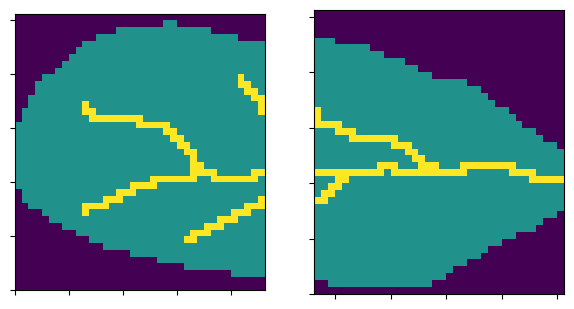

In [46]:
fig = plt.figure(figsize=(figwidth, 0.55*figheight))

for i,m in enumerate(parallel_sim.model_names):
  ax = fig.add_subplot(1,nr_domains,i+1)
  pmv = flopy.plot.PlotMapView(models[i])
  idomain = models[i].modelgrid.idomain
  pmv.plot_array(idomain[0], vmax=2)
  
  ax.set_xticklabels([])
  ax.set_yticklabels([])



Check if the model partitions are evenly split

In [47]:
for m in models:
  idomain = m.modelgrid.idomain
  print(f"Nr. of active cells in {m.name}:", np.count_nonzero(idomain))
  

Nr. of active cells in model_0: 5640
Nr. of active cells in model_1: 4775
